In [1]:
from __future__ import division 
import numpy as np 
import seaborn 
#import sys
#import csv
import pandas as pd 
#from scipy import io
#from scipy import stats
#from scipy import linalg as la
from scipy.sparse import coo_matrix
from scipy.sparse import linalg as sparla
from matplotlib import pyplot as plt 

#from sklearn import cluster # From GPR
#from sklearn.naive_bayes import GaussianNB # From old naive bayes
#from sklearn import cross_validation # From old naive bayes
#from sklearn.naive_bayes import MultinomialNB # From old naive bayes

%matplotlib inline 

%pylab inline 
pylab.rcParams['figure.figsize'] = (16.0, 8.0) # Control figure size 

Populating the interactive namespace from numpy and matplotlib


Now that we have all our relevant import statements, we load the data. For ease of use, all data will be stored in pandas dataframes.

In [2]:
# User, Movie pairs to make predictions for

to_predict = pd.read_table('predictions.dat')

################################################################################

movies = pd.read_table('movie_training_data\movies.dat')

genres = pd.read_table('movie_training_data\movie_genres.dat')

directors = pd.read_table('movie_training_data\movie_directors.dat')

actors = pd.read_table('movie_training_data\movie_actors.dat')

countries = pd.read_table('movie_training_data\movie_countries.dat')

locations = pd.read_table('movie_training_data\movie_locations.dat')

# Set of tags available in the dataset
tags = pd.read_table('movie_training_data\\tags.dat')

user_taggedmovies = pd.read_table('movie_training_data\user_taggedmovies.dat')

# Tags assigned to the moveies, with counts
movie_tags = pd.read_table('movie_training_data\movie_tags.dat')

# Core training data
urmt_string = 'movie_training_data\user_ratedmovies_train.dat'
user_ratedmovies_train = pd.read_table(urmt_string)

We take a preliminary look at the variables available in each dataset. Notice that the 'id' column in the movies and tags datasets is the same as the movieID column in the other datasets, which can easily be checked by looking at the number of unique 'movieID' values in the other datasets and comparing to the 'id' column in 'movies' and the total number of movies.

In [3]:
def view_df(df, name):
    
    df_cols = list(df.columns)
    print '\n', name, ': ', df.shape[0], ' entries \n'
    
    for i in xrange(len(df_cols)):
        print '\t', df_cols[i]

view_df(to_predict, 'test data pairs')
view_df(movies, 'movies')
view_df(genres, 'genres')
view_df(directors, 'directors')
view_df(actors, 'actors')
view_df(countries, 'countries')
view_df(locations, 'locations')
view_df(tags, 'tags')
view_df(user_taggedmovies, 'user tagged movies')
view_df(user_ratedmovies_train, 'user rated movies')


test data pairs :  85000  entries 

	testID
	userID
	movieID

movies :  10197  entries 

	id
	title
	imdbID
	spanishTitle
	imdbPictureURL
	year
	rtID
	rtAllCriticsRating
	rtAllCriticsNumReviews
	rtAllCriticsNumFresh
	rtAllCriticsNumRotten
	rtAllCriticsScore
	rtTopCriticsRating
	rtTopCriticsNumReviews
	rtTopCriticsNumFresh
	rtTopCriticsNumRotten
	rtTopCriticsScore
	rtAudienceRating
	rtAudienceNumRatings
	rtAudienceScore
	rtPictureURL

genres :  20809  entries 

	movieID
	genre

directors :  10155  entries 

	movieID
	directorID
	directorName

actors :  231742  entries 

	movieID
	actorID
	actorName
	ranking

countries :  10197  entries 

	movieID
	country

locations :  49167  entries 

	movieID
	location1
	location2
	location3
	location4

tags :  13222  entries 

	id
	value

user tagged movies :  47957  entries 

	userID
	movieID
	tagID
	date_day
	date_month
	date_year
	date_hour
	date_minute
	date_second

user rated movies :  770598  entries 

	Unnamed: 0
	userID
	movieID
	rating
	dat

Now we get some statistics and make some plots to look at the distribution of various aspects of the data.

Statistics already available in readme.txtData statistics:

* 2113 users
* 10197 movies

* 20 movie genres
* 20809 movie genre assignments
    * avg. 2.040 genres per movie

* 4060 directors
* 95321 actors
    * avg. 22.778 actors per movie
* 72 countries

* 10197 country assignments
     * avg. 1.000 countries per movie
* 47899 location assignments
     * avg. 5.350 locations per movie

* 13222 tags
* 47957 tag assignments (tasg), i.e. tuples [user, tag, movie]
     * avg. 22.696 tags per user
     * avg. 8.117 tags per movie

* 855598 ratings (doesn't match- we have 770598) 
     * avg. 404.921 ratings per user (we have 364.69)
     * avg. 84.637 ratings per movie (76.73)

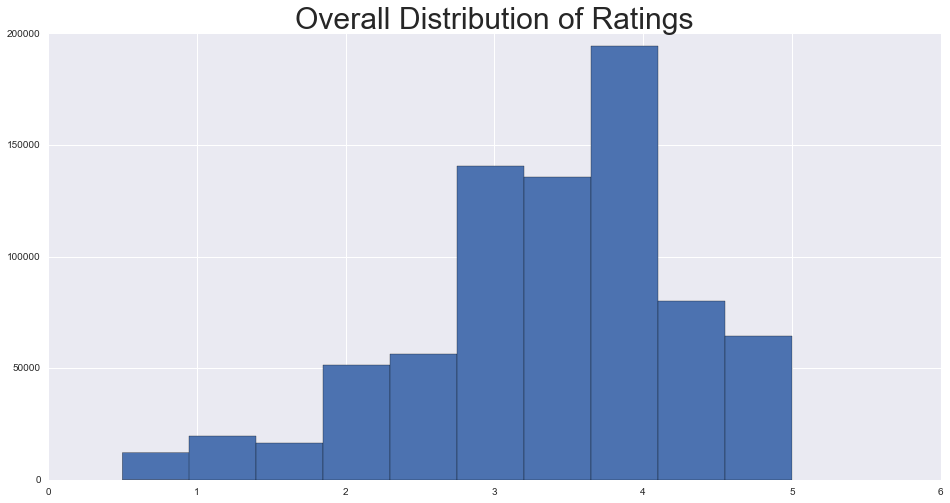

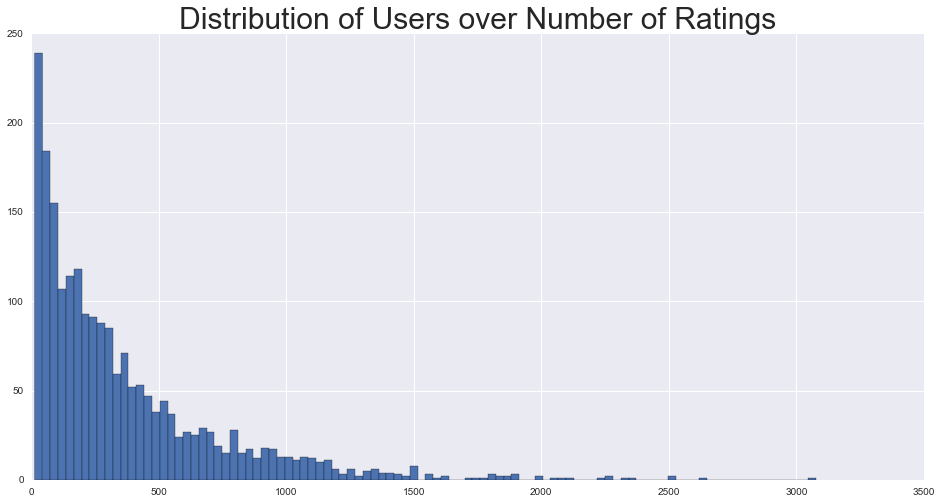

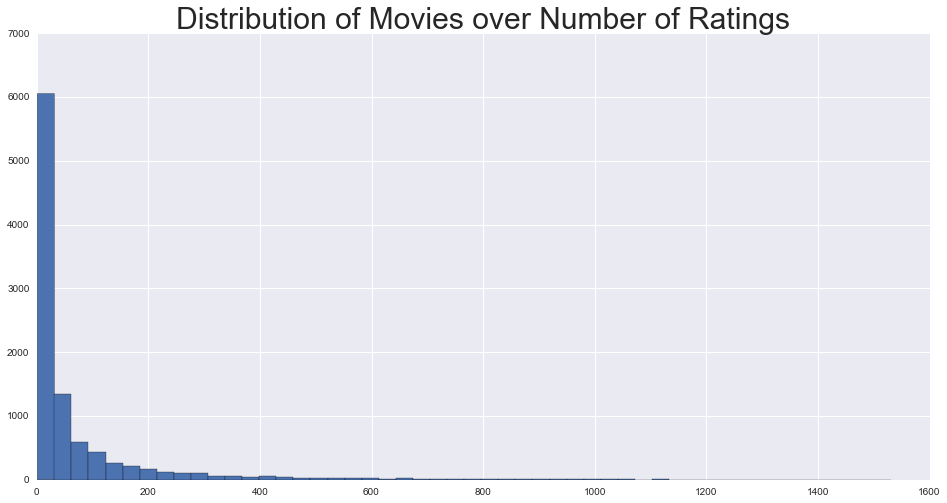

5430


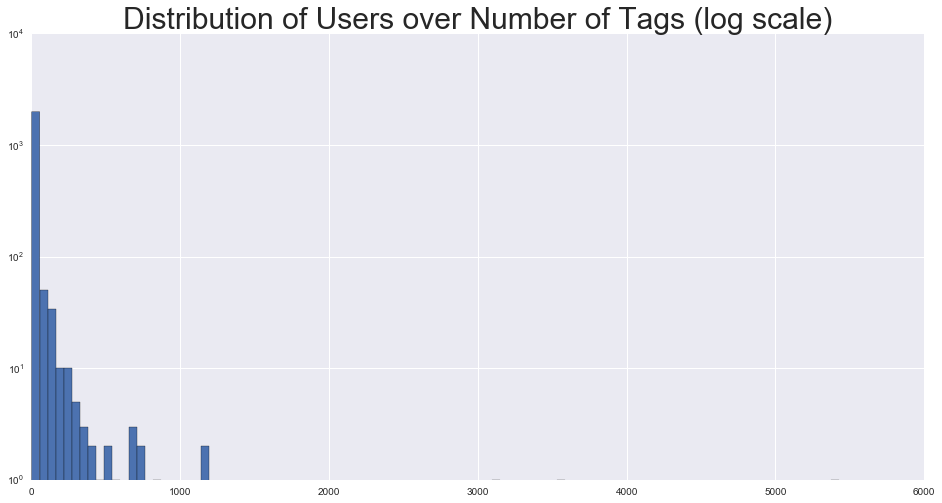

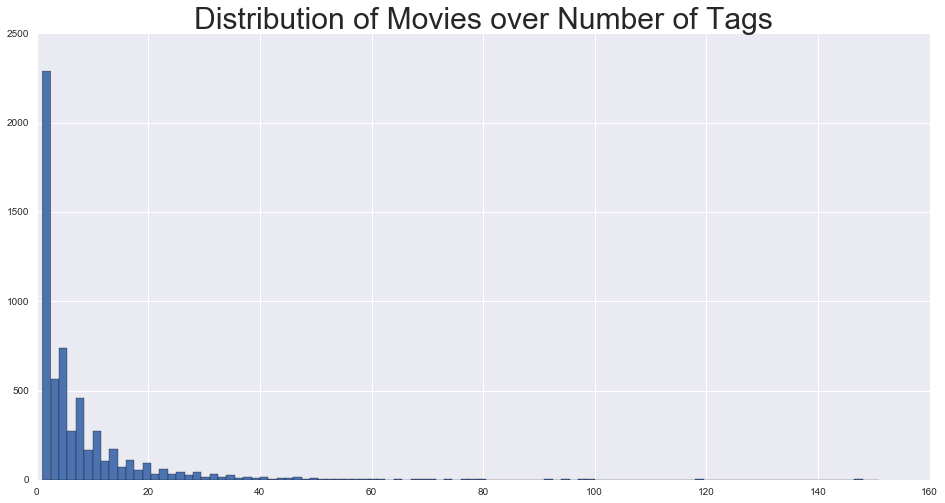

In [5]:
ax = user_ratedmovies_train['rating'].hist()
ax.set_title('Overall Distribution of Ratings',size=30)
plt.show()

ratings = user_ratedmovies_train.groupby(['userID']).count()['rating']
ax = ratings.hist(bins=100)
ax.set_title('Distribution of Users over Number of Ratings', size=30)
plt.show()

ratings = user_ratedmovies_train.groupby(['movieID']).count()['rating']
ax = ratings.hist(bins=50)
ax.set_title('Distribution of Movies over Number of Ratings', size=30)
plt.show()

tagnumbers = user_taggedmovies.groupby(['userID']).count()['tagID']
print np.max(tagnumbers)
ax = tagnumbers.hist(bins=100, log=True)
ax.set_title('Distribution of Users over Number of Tags (log scale)', size=30)
plt.show()

tagnumbers = user_taggedmovies.groupby(['movieID']).count()['tagID']
ax = tagnumbers.hist(bins=100)
ax.set_title('Distribution of Movies over Number of Tags', size=30)
plt.show()

We see that most users have a small number of ratings and a small number of tags, while a few have a very higher. This is most pronounced in the distribution of users over number of tags, to the point where it necessitates a log scale. 

Likewise, most movies have a small number of ratings, while a small number have a high number of ratings.

The distribution of the ratings themselves is not uniform; ratings of 4 are the most common, 3-3.5 are significantly more common than >4, which are in turn more common than ratings of 2.5, while ratings of less than 2 are significantly more rare.

We now look at the highest rated movies before proceeding with the recommender.

In [6]:
ratings = user_ratedmovies_train.groupby(['movieID'])

# Only select movies with more than ten ratings, to avoid the problem where
# a small number of positive ratings ruins everything.
wellrated = ratings.mean()['rating'][(ratings.count()['rating'] > 10)]
highrated = wellrated.nlargest(50)
vals = highrated.index.values

for i in xrange(len(vals)):
    score = "{0:.2f}".format(highrated[vals[i]])
    title =  movies[movies['id'] == vals[i]]['title'].values[0]
    director = directors[directors['movieID'] == vals[i]]['directorName'].values[0]
    print i+1, '\t', score, '\t', title, '\n\t\t- ', director

1 	4.38 	The Life and Death of Colonel Blimp 
		-  Emeric Pressburger
2 	4.38 	Seppuku 
		-  Masaki Kobayashi
3 	4.37 	The Shawshank Redemption 
		-  Frank Darabont
4 	4.37 	Dom za vesanje 
		-  Emir Kusturica
5 	4.35 	Rang-e khoda 
		-  Majid Majidi
6 	4.35 	Mus�me si pom�hat 
		-  Jan Hrebejk
7 	4.33 	Dead of Night 
		-  Deryn Warren
8 	4.32 	The Godfather 
		-  Francis Ford Coppola
9 	4.32 	Le notti di Cabiria 
		-  Federico Fellini
10 	4.32 	Ballada o soldate 
		-  Grigori Chukhraj & Valentin Yezhov
11 	4.29 	All About Eve 
		-  Joseph L. Mankiewicz
12 	4.29 	Becket 
		-  Peter Glenville
13 	4.29 	A Patch of Blue 
		-  Guy Green
14 	4.28 	The Usual Suspects 
		-  Bryan Singer
15 	4.28 	Cocaine Cowboys 
		-  Billy Corben
16 	4.28 	A Man for All Seasons 
		-  Fred Zinnemann
17 	4.28 	Gigantic (A Tale of Two Johns) 
		-  AJ Schnack
18 	4.28 	Double Indemnity 
		-  Billy Wilder
19 	4.27 	Ordet 
		-  Kaj Munk
20 	4.27 	Mimi wo sumaseba 
		-  Yoshifumi Kondo
21 	4.26 	Fight Club 
		-  Da

# Recommender System

We start by splitting up our available data into training and test data and defining some helper functions.

# Matrix Factorization

We represent the ratings already given by the users as a sparsely observed matrix, which we want to approximate by the product of two low-rank fully
observed matrices. Then, to get the predicted rating for a user/movie pair,
we simply take the dot product of the appropriate row and column. 

Since the test pairs are given as (user, movie) pairs, we let the users be the rows, while the movies are the columns. So the (i,j)th entry of the full matrix is the rating given by the i-th userID for the j-th movieID. 

The matrix dimensions are significantly larger than (number of users) x (number of movies), since the userIDs and movieIDs both get larger than that.

In this case, the rank of the decomposition matrices represents the number of 
latent features we are using for the approximation.

We use a gradient descent method and also add a regularization term to minimize the norm of the decomposition matrices and avoid overfitting.



We also notice that the minimum rating a user can give in this case is 0.5,
so we may use a sparse matrix whose non-observed entries are stored as zeros.

We test the model for rank 1 and rank 3 approximations, and for both 10 and 50 steps of the gradient descent method (50 steps only in the rank 1 case)


Source: http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/

In [77]:
# Lower RMSE values are better. 
def RMSE(predicted_ratings, true_ratings):
    return np.sqrt(np.mean( (predicted_ratings - true_ratings)**2 ))

def test_split(data, n):
    """ 
    Return randomly chosen test_data, train_data from a Pandas DataFrame,
    where test_data contains n values.
    """
    all_inds = np.random.permutation(range(0,len(data)))
    
    return data.iloc[all_inds[:n]], data.iloc[all_inds[n:]]

def factorize(R, P, Q, K, maxiters, alpha, beta):
    """
    Get a low-rank approximation of the partially observed matrix R using
    the initial guesses P and Q, both of rank k. Run the algorithm for a 
    maximum of maxiters steps.
    
    alpha represents the step size to use for gradient descent and 
    """
    Q = Q.T
    
    for step in xrange(maxiters):
        print step, '\r'
        # Iterate over the explicitly stored entries in R
        for n in xrange(R.nnz):
            i, j, data = R.row[n], R.col[n], R.data[n]
            
            # Get the difference between the actual and predicted value
            # for the user, movie pairing
            eij = data - np.dot(P[i,:],Q[:,j])
            
            for k in xrange(K):
                P[i,k] += alpha*(2*eij*Q[k,j] - beta*P[i,k])
                Q[k,j] += alpha*(2*eij*P[i,k] - beta*Q[k,j])
        
        """
        eR = np.dot(P,Q)
        e = 0
        for n in xrange(R.nnz):
            i, j, data = R.row[n], R.col[n], R.data[n]
            
            e += (data - np.dot(P[i,:],Q[:,j]))**2
            for k in xrange(K):
                e += beta/2 * (P[i,k]**2 + Q[k,j]**2)
        if e < 0.001:
            break
        """
    return P, Q.T

def run_factorization(R, k, alpha, beta):
    """
    Run the matrix factorization on R of rank k with given parameters.
    """
    
   
    """
    I'm leaving this code in to show you what I wasted like an hour and a 
    half on.
    
    I thought this would be a good idea, before I realized how absolutely 
    huge this stupid matrix is. It took several memory errors to realize.
    
    # First, we get what should be a reasonable initial guess for P and Q
    # by filling in the zero entries of R with the average rating for the
    # each movie and then taking the rank k SVD approximation.
    #avg_ratings = np.tile(np.nanmean(np.where(A>0, A, np.nan),0), (A.shape[0],1))
    #R0 = np.putmask(A, A==0, avg_ratings)
    A = R.toarray()
    for j in xrange(A.shape[1]):
        col_sum = np.sum(A[:,j])
        col_num = np.count_nonzero(A[:,j])
        mean = col_sum/max(col_num,1)
        for i in xrange(A.shape[0]):
            if A[i,j] == 0:
                A[i,j] = mean
    print A.shape
    print np.count_nonzero(A)
    #U, s, Vh = la.svd(R0, full_matrices=False)
    
    #print np.dot(U,np.diag(s)).shape, Vh.shape
    """
    M, N = R.shape
    print M, N
    
    # For our initial guess, we fill P and Q randomly
    P = np.random.rand(M,k)
    Q = np.random.rand(N,k)
    
    P, Q = factorize(R, P, Q, k, 50, alpha, beta)
    
    return P, Q
    
# The minimum rating possible for a user to give
#print min(user_ratedmovies_train.groupby(['userID']).min()['rating'])
    
# Split the data into test and training data
test_ur, ur = test_split(user_ratedmovies_train, 85000)

# There's a really large discrepancy between the number of unique userIDs and
# the value of the userIDs. I spent probably at least an hour trying to figure out
# how to take advantage of this to make the R matrix smaller, but wasn't able to 
# get it to work.
#user_inds = np.unique(ur['userID'])
#movie_inds = np.unique(ur['movieID'])

#print user_inds
R = coo_matrix((ur['rating'], (ur['userID'], ur['movieID'])))
#print R.nnz
#print R.shape

#2113 users
#10197 movies
#print len(np.unique(np.array(ur['userID'])))
#print len(np.unique(np.array(ur['movieID'])))

# 71534 is highest userID
# 65133 is highest movieID
#print max(ur['userID'])
#print max(ur['movieID'])


#print R.shape
#print R.nnz
#for k in xrange(100):
#    print R.row[k], R.col[k], R.data[k]

In [79]:
P, Q = run_factorization(R, 3, 0.0002, 0.02)

71535 65134
0 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 
25 
26 
27 
28 
29 
30 
31 
32 
33 
34 
35 
36 
37 
38 
39 
40 
41 
42 
43 
44 
45 
46 
47 
48 
49 


In [81]:
# Test for 50 steps of gradient descent with rank 3

predictions = np.zeros(85000)
test_users = np.array(test_ur['userID'])
test_movies = np.array(test_ur['movieID'])

for i in xrange(85000):
    predictions[i] = np.dot(P[test_users[i],:], Q[test_movies[i],:])
        
print predictions[:10]
print np.array(test_ur['rating'])[:10]
print RMSE(predictions, np.array(test_ur['rating']))

predictions = np.zeros(85000)
test_users = np.array(ur['userID'])
test_movies = np.array(ur['movieID'])

for i in xrange(85000):
    predictions[i] = np.dot(P[test_users[i],:], Q[test_movies[i],:])
        
print RMSE(predictions, np.array(ur['rating'])[:85000])

[ 3.51859029  4.2434424   2.53145484  3.99177101  4.1313412   3.89920413
  2.90090718  3.08222065  3.3711909   3.11034704]
[ 3.   4.5  2.   4.5  3.   4.5  3.   3.5  3.   4. ]
0.830101598906
0.816903364411


In [76]:
# Test for 10 steps of gradient descent with rank 3

predictions = np.zeros(85000)
test_users = np.array(test_ur['userID'])
test_movies = np.array(test_ur['movieID'])

for i in xrange(85000):
    predictions[i] = np.dot(P[test_users[i],:], Q[test_movies[i],:])
        
print predictions[:10]
print np.array(test_ur['rating'])[:10]
print RMSE(predictions, np.array(test_ur['rating']))

predictions = np.zeros(85000)
test_users = np.array(ur['userID'])
test_movies = np.array(ur['movieID'])

for i in xrange(85000):
    predictions[i] = np.dot(P[test_users[i],:], Q[test_movies[i],:])
        
print RMSE(predictions, np.array(ur['rating'])[:85000])

[ 4.47499303  3.64720749  3.68271182  3.89148014  3.36126715  4.06508144
  3.6246218   2.92185026  2.2660899   3.68193234]
[ 4.5  3.5  3.5  4.   2.   3.5  4.   2.   3.5  4. ]
0.973789077009
0.971566944793


In [71]:
# Test for 50 steps of gradient descent with rank 1

predictions = np.zeros(85000)
test_users = np.array(test_ur['userID'])
test_movies = np.array(test_ur['movieID'])

for i in xrange(85000):
    predictions[i] = np.dot(P[test_users[i],:], Q[test_movies[i],:])
        
print predictions[:10]
print np.array(test_ur['rating'])[:10]
print RMSE(predictions, np.array(test_ur['rating']))

predictions = np.zeros(85000)
test_users = np.array(ur['userID'])
test_movies = np.array(ur['movieID'])

for i in xrange(85000):
    predictions[i] = np.dot(P[test_users[i],:], Q[test_movies[i],:])
        
print RMSE(predictions, np.array(ur['rating'])[:85000])

[ 3.08297196  4.4057901   3.00362188  3.32425548  4.27550272  3.0932112
  3.39027094  2.97980586  1.7792327   2.94543019]
[ 3.5  4.5  4.   4.   4.5  2.5  5.   3.   2.   3.5]
0.851666219351
0.830919084052


In [68]:
# Test for only 10 steps of gradient descent with rank 1

predictions = np.zeros(85000)
test_users = np.array(test_ur['userID'])
test_movies = np.array(test_ur['movieID'])

for i in xrange(85000):
    predictions[i] = np.dot(P[test_users[i],:], Q[test_movies[i],:])
        
print predictions[:10]
print np.array(test_ur['rating'])[:10]
print RMSE(predictions, np.array(test_ur['rating']))


[ 3.79425981  3.38676675  2.62707037  3.16887956  3.32167482  3.03474408
  1.80070424  3.11825701  3.67749538  3.71131899]
[ 3.   2.5  4.   3.   4.   3.5  4.   4.   4.   4. ]
1.12297627619


For my private test/training split, my final RMSE for the various parameters was as follows:
* 1.122 for 10 steps of gradient descent with a rank 1 approximation
* 0.851 for 50 steps of gradient descent with a rank 1 approximation
* 0.973 for 10 steps of gradient descent with a rank 3 approximation
* 0.830 for 50 steps of gradient descent with a rank 3 approximation

From these results, it looks like the higher rank approximation converges more quickly, but when run for a higher number of steps, it doesn't do much better than the rank 1 approximation.

I noticed when writing my code that it was incredibly easy to run into memory errors. The matrix factorization tutorial I based my code on used 3000 steps of gradient descent, multiplied matrices willy-nilly, and also used a convergence condition to see if it needed to break early. This was not at all feasible for this dataset. For matrices this large, finding the error term used to determine convergence is too computationally expensive and requires too much memory to be worth the effort, so I chose to ignore that part of the algorithm and simply run the descent for a fixed number of steps. This made things MUCH faster.

To check for overfitting, I checked the RMSE value for the first 85000 ratings in the training set and compared it to the RMSE for the test data. For the test with 10 steps of gradient descent and a rank 1 approximation, I got an RMSE of 0.851 for my test data and 0.830 for my training data. Likewise, when I ran 10 steps of gradient descent with a rank 3 approximation, I got 0.973 and 0.971. Since the accuracy of the predictions for the training data was not very different from the accuracy for the test data, I know I'm not overfitting.

Since my algorithm can produce better results simply by varying parameters (and making it take longer to run), and my results are comparable/better to those my classmates were discussing on slack, I am using the first one for my submission. It's also taking a fairly reasonable amount of time to run. Not fast, the 50 step rank 3 approximation took about 20 minutes, but that's really not terrible compared to some of the other labs we've done.

I would have tried Naive Bayes, but I chose to try matrix factorization first and definitely didn't have enough time to do Naive Bayes as well.

I am generating the prediction using the rank 3 approximation with 50 steps of gradient descent, since this combination of parameters gave the best RMSE result.

In [85]:
# Generate predictions for to_predict and save as .csv

predictions = np.zeros(85000)
test_users = np.array(to_predict['userID'])
test_movies = np.array(to_predict['movieID'])

for i in xrange(85000):
    predictions[i] = np.dot(P[test_users[i],:], Q[test_movies[i],:])
        
print predictions[:10]
output_array = np.zeros((85000,2))
output_array[:,1] = predictions
output_array[:,0] = np.array(to_predict['testID'])

np.savetxt('predictions.csv', output_array)

[ 3.81616371  3.54792389  3.11359596  4.57094979  3.91874075  1.58124342
  3.94818223  3.34423614  1.95681782  3.85139168]
